In [12]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
# County Data with fips county data for geolocation
County_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
C_df = pd.read_csv(County_url)
print(C_df.head())

         date     county       state     fips  cases  deaths
0  2020-01-21  Snohomish  Washington  53061.0      1       0
1  2020-01-22  Snohomish  Washington  53061.0      1       0
2  2020-01-23  Snohomish  Washington  53061.0      1       0
3  2020-01-24       Cook    Illinois  17031.0      1       0
4  2020-01-24  Snohomish  Washington  53061.0      1       0


In [14]:
df = C_df.loc[C_df['fips'] == 39061]
df

,date,county,state,fips,cases,deaths
4935,2020-03-19,Hamilton,Ohio,39061.0,2,0
5798,2020-03-20,Hamilton,Ohio,39061.0,7,0
6798,2020-03-21,Hamilton,Ohio,39061.0,8,0
7908,2020-03-22,Hamilton,Ohio,39061.0,19,0
9112,2020-03-23,Hamilton,Ohio,39061.0,26,0
10432,2020-03-24,Hamilton,Ohio,39061.0,38,0
11885,2020-03-25,Hamilton,Ohio,39061.0,48,0
13501,2020-03-26,Hamilton,Ohio,39061.0,53,0
15249,2020-03-27,Hamilton,Ohio,39061.0,63,0
17102,2020-03-28,Hamilton,Ohio,39061.0,71,0


In [15]:
df = df.loc[:,['date','cases','fips','deaths']]
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days  )

In [16]:
df

,date,cases,fips,deaths
4935,78,2,39061.0,0
5798,79,7,39061.0,0
6798,80,8,39061.0,0
7908,81,19,39061.0,0
9112,82,26,39061.0,0
10432,83,38,39061.0,0
11885,84,48,39061.0,0
13501,85,53,39061.0,0
15249,86,63,39061.0,0
17102,87,71,39061.0,0


In [17]:
# Calculate the general percentage of infection by dividing the number of new cases
# by the average census and multiplying by 100.
# For more specific rates, divide the number of new cases by total resident days and multiply by 1000,
# which gives you the number of infections per 1000 resident days.
# Montgomery county current population = 531,669

# New cases divided by population for infection rate
popu = 814671
new_cases = df.iloc[-1,1]
infection_rate = (new_cases/popu)*1000
print(infection_rate)
current_cases = df.iloc[-1,1]
current_date = df.iloc[-1,0]
# print("Current date delta: ",current_date,"Current cases: ",current_cases)

0.6567068178442587


In [18]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [19]:
a = infection_rate # Infection rate
b = df.iloc[-1,0] # df.date[-1:] # Current date num
c = df.iloc[-1,1] # df.cases[-1:] # Current case num
x = list(df.iloc[:,0])
y = list(df.iloc[:,1])
fit = curve_fit(logistic_model,x,y,p0=[5,20,2000])
fit

(array([  3.61662535,  94.71024495, 618.9145041 ]),
 array([[2.63042531e-02, 4.00884231e-02, 2.61174852e+00],
        [4.00884231e-02, 9.14476610e-02, 5.50619643e+00],
        [2.61174852e+00, 5.50619643e+00, 3.64423268e+02]]))

In [20]:
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
print(errors)

[0.16218585979483763, 0.30240314311772726, 19.089873432842086]


In [21]:
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))

/home/chuk/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


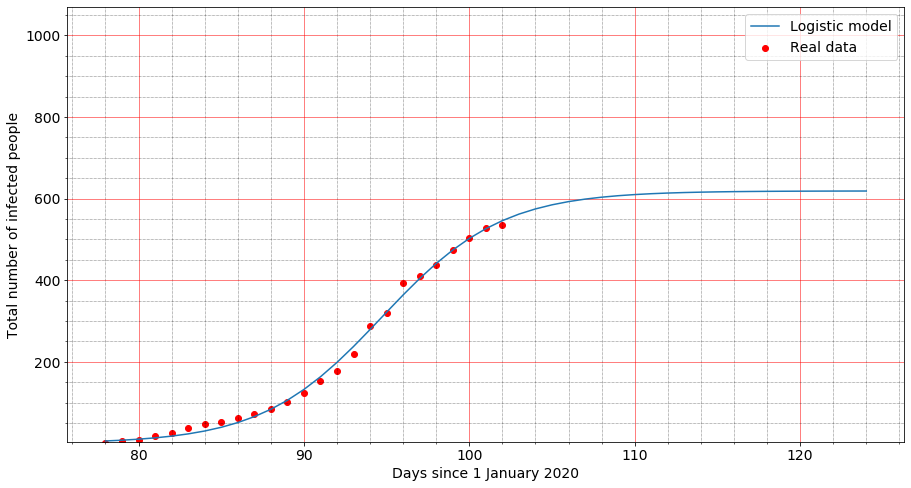

In [22]:
pred_x = list(range(max(x),sol))
plt.rcParams['figure.figsize'] = [15, 8]

plt.rc('font', size=14)

# Real data
plt.scatter(x,y,label="Real data",color="red")

# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" )

plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Total number of infected people")
plt.ylim((min(y)*2.0,c*2.0))

# plt.grid()

# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()

# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')